In [162]:
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np
import mediapipe as mp
from time import process_time
import os

In [163]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # FATAL
os.environ["GLOG_minloglevel"] ="2"

In [164]:
dict ={
    0: "WRIST",
    1: "THUMB_CMC",
    2: "THUMB_MCP",
    3: "THUMB_IP",
    4: "THUMB_TIP",
    5: "INDEX_FINGER_MCP",
    6: "INDEX_FINGER_PIP",
    7: "INDEX_FINGER_DIP",
    8: "INDEX_FINGER_TIP",
    9:  "MIDDLE_FINGER_MCP",
    10: "MIDDLE_FINGER_PIP",
    11: "MIDDLE_FINGER_DIP",
    12: "MIDDLE_FINGER_TIP",
    13: "RING_FINGER_MCP",
    14: "RING_FINGER_PIP",
    15: "RING_FINGER_DIP",
    16: "RING_FINGER_TIP",
    17: "PINKY_MCP",
    18: "PINKY_PIP",
    19: "PINKY_DIP",
    20: "PINKY_TIP",
}
mp_hands = mp.solutions.hands
hands = mp_hands.Hands( 
    static_image_mode= True,
    max_num_hands = 1,
    min_detection_confidence=0.5)

In [165]:
## Transform the image to a vector with 21 coordinates.
def image_to_vector(img):
    try:
        result_vector =[]
        result = hands.process(img)

        for hand_landmark in result.multi_hand_world_landmarks:
            for item in dict:
                landmarkObj = hand_landmark.landmark[mp_hands.HandLandmark[dict[item]]]
                result_vector.append([landmarkObj.x,landmarkObj.y, landmarkObj.z])
        
        return np.array(result_vector, dtype=np.float64)
    
    except:
        return np.reshape(np.zeros(63, dtype=np.float64), (21,3))

In [166]:
def NormalizeData(data):
    for i in range(len(data)):
        data[i] = (data[i] - np.min(data[i])) / (np.max(data[i]) - np.min(data[i]))
    return data

In [167]:
def Flip(data, p=0.5, axis=0):
    for i in range(len(data)):
        if np.random.random() < p:
            for j in range(3):
                if(axis != j):
                    data[i][j] = -1* data[i][j]
    return data

In [168]:
## Load dataset
(train_images,train_labels) = tfds.as_numpy(tfds.load('rock_paper_scissors', split='train[:70%]', batch_size=-1, as_supervised = True))
(validation_images,validation_labels) = tfds.as_numpy(tfds.load('rock_paper_scissors', split='train[70%:]', batch_size=-1, as_supervised = True))
(test_images,test_labels) = tfds.as_numpy(tfds.load('rock_paper_scissors', split='test', batch_size=-1, as_supervised = True))

In [169]:
#Transform the images to vectors
train_map = map(image_to_vector, train_images)
test_map = map(image_to_vector, test_images)
validation_map = map(image_to_vector, validation_images)

In [170]:
raw_train_data = np.array(list(train_map))
raw_test_data = np.array(list(test_map))
raw_validation_data = np.array(list(validation_map))

In [171]:
train_array = np.reshape(raw_train_data, (-1, 63))
test_array = np.reshape(raw_test_data, (-1, 63))
validation_array = np.reshape(raw_validation_data, (-1, 63))

In [172]:
#Check where sum of a row is not 0
train_data, train_labels =  train_array[np.where(np.sum(train_array,axis=1) != 0)], train_labels[np.where(np.sum(train_array,axis=1) != 0)]
test_data, test_labels =  test_array[np.where(np.sum(test_array,axis=1) != 0)], test_labels[np.where(np.sum(test_array,axis=1) != 0)]
validation_data, validation_labels =  validation_array[np.where(np.sum(validation_array,axis=1) != 0)], validation_labels[np.where(np.sum(validation_array, axis=1) != 0)]

In [173]:
train_normalized = NormalizeData(train_data)
test_normalized = NormalizeData(test_data)
validation_normalized = NormalizeData(validation_data)

In [174]:
train_normalized = np.reshape(train_normalized, (-1, 21, 3))
test_normalized = np.reshape(test_normalized, (-1, 21, 3))
validation_normalized = np.reshape(validation_normalized, (-1, 21, 3))

In [175]:
train_normalized = Flip(train_normalized, p=0.15, axis=0)
test_normalized = Flip(test_normalized, p=0.15, axis=0)
validation_normalized = Flip(validation_normalized, p=0.15, axis=0)

train_normalized = Flip(train_normalized, p=0.15, axis=1)
test_normalized = Flip(test_normalized, p=0.15, axis=1)
validation_normalized = Flip(validation_normalized, p=0.15, axis=1)

train_normalized = Flip(train_normalized, p=0.15, axis=2)
test_normalized = Flip(test_normalized, p=0.15, axis=2)
validation_normalized = Flip(validation_normalized, p=0.15, axis=2)

In [188]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('loss') < 0.01):
            print("\nReached 1% loss so cancelling training!")
            self.model.stop_training = True

In [192]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(21, 3)),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')])

In [193]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [194]:
history=model.fit(train_normalized, train_labels, epochs=20, batch_size=10, callbacks=[myCallback()], validation_data=(validation_normalized, validation_labels))

Epoch 1/20
169/169 [==============================] - 4s 14ms/step - loss: 0.9349 - accuracy: 0.7010 - val_loss: 0.7630 - val_accuracy: 0.9053
Epoch 2/20
169/169 [==============================] - 2s 9ms/step - loss: 0.6080 - accuracy: 0.9364 - val_loss: 0.4629 - val_accuracy: 0.9506
Epoch 3/20
169/169 [==============================] - 2s 11ms/step - loss: 0.3555 - accuracy: 0.9578 - val_loss: 0.2707 - val_accuracy: 0.9506
Epoch 4/20
169/169 [==============================] - 2s 10ms/step - loss: 0.2061 - accuracy: 0.9780 - val_loss: 0.1553 - val_accuracy: 0.9849
Epoch 5/20
169/169 [==============================] - 2s 9ms/step - loss: 0.1261 - accuracy: 0.9875 - val_loss: 0.0995 - val_accuracy: 0.9904
Epoch 6/20
169/169 [==============================] - 2s 10ms/step - loss: 0.0846 - accuracy: 0.9929 - val_loss: 0.0732 - val_accuracy: 0.9959
Epoch 7/20
169/169 [==============================] - 2s 10ms/step - loss: 0.0600 - accuracy: 0.9946 - val_loss: 0.0626 - val_accuracy: 0.9945
E

In [195]:
model.evaluate(test_normalized, test_labels)

12/12 [==============================] - 0s 5ms/step - loss: 0.0022 - accuracy: 1.0000


[0.002207792829722166, 1.0]

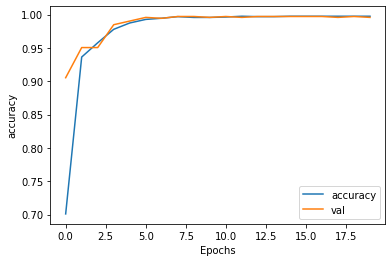

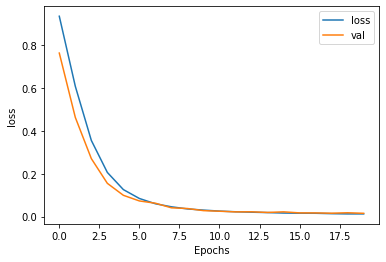

In [196]:
import matplotlib.pyplot as plt

# Plot utility
def plot_graphs(history, string):
  plt.plot(history.history[string], label=string)
  plt.plot(history.history['val_'+string], label= "val")
  plt.legend()
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.show()

# Visualize the accuracy
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [160]:
model.save_weights('../models/dnn_model_weights.h5')
model.save('../models/dnn_model.h5')